In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../src/rna_transform")
sys.path.append("../src/qspright")

import rna_transform.utils as utils
from rna_transform.rna_helper import RNAHelper
from qspright.utils import best_convex_underestimator
import itertools

# import tqdm and solve a visualisation problem with tqdm
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

# set parallelism
parallel = True

if parallel:
    from multiprocessing import Pool

In [2]:
positions = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

helper = RNAHelper(positions)
n = helper.n
q = helper.q

print("n = {}, N = {}".format(n, q ** n))

n = 10, N = 1048576


## Calculate free energies of different RNA sequences

Constructs and save the data corresponding to the quasi-empirical RNA fitness function of the Hammerhead ribozyme HH9.

In [3]:
# helper.calculate_rna_data(parallel=parallel)

### Calculate true values of the GWHT coefficients

Calculates the GWHT transform of the RNA free energy values using vanilla FFT.

In [4]:
emp_beta_gwht = helper.compute_rna_model(method="gwht", save=False)

Found GWHT coefficients


In [5]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_gwht = utils.calc_frac_var_explained(emp_beta_gwht)

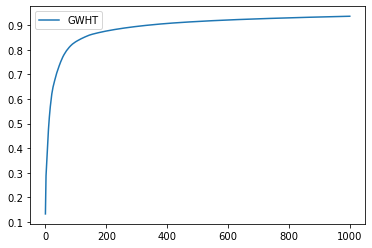

In [6]:
plt.plot(bm_fv_gwht[:1000], label = "GWHT")
plt.legend()
plt.show()

## Test QSPRIGHT with different parameters

Construct a grid of parameters. For each entry, run multiple test rounds. Compute the average for each parameter selection. 

In [7]:
iters = 1
num_subsample_list = [2, 3, 4, 5]
num_random_delays_list = [3, 5, 7, 9]
b_list = [4, 5, 6, 7]
test_params_list = list(itertools.product(num_subsample_list, num_random_delays_list, b_list))

def _gwht_test(i):
    param_idx = i % len(test_params_list)
    test_params = test_params_list[param_idx]
    num_subsample, num_random_delays, b = test_params
    
    # set model arguments
    model_kwargs = {}
    model_kwargs["save"] = False
    model_kwargs["noise_sd"] = 800 / (q ** n)
    model_kwargs["report"] = True
    model_kwargs["num_subsample"] = num_subsample
    model_kwargs["num_random_delays"] = num_random_delays
    model_kwargs["b"] = b
    model_kwargs["on_demand_comp"] = not parallel

    gwht, (n_used, n_used_unique, used_unique), peeled = helper.compute_rna_model(method = "qspright", **model_kwargs)
    emp_beta_qspright = np.reshape(gwht, -1)
    
    # calculate metrics
    sample_ratio = n_used / q ** n
    unique_sample_ratio = n_used_unique/ q ** n
    nmse = np.sum(np.abs(emp_beta_gwht - emp_beta_qspright)**2) / np.sum(np.abs(emp_beta_gwht)**2)
    
    #print(len(peeled), nmse)
    return param_idx, sample_ratio, unique_sample_ratio, nmse

In [8]:
if parallel:
    
    exp_count = iters * len(test_params_list)

    with Pool() as pool:
        pred = list(tqdm(pool.imap(_gwht_test, range(exp_count)), total=exp_count))

else:
    # TODO
    raise NotImplementedError("non-parallel version is not implemented")

100%|██████████| 64/64 [01:19<00:00,  1.24s/it]


In [9]:
test_params_idx_list = list(itertools.product(np.arange(len(num_subsample_list)), np.arange(len(num_random_delays_list)), np.arange(len(b_list))))

sample_ratios = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))
unique_sample_ratios = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))
nmses = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))

for i, exp_result in enumerate(pred):
    iter_idx = i // len(test_params_list)
    test_params_idx = i % len(test_params_list)
    test_params_idx = test_params_idx_list[test_params_idx]
    param_idx, sample_ratio, unique_sample_ratio, nmse = exp_result
    idx = test_params_idx + (iter_idx,)
    sample_ratios[idx] = sample_ratio
    unique_sample_ratios[idx] = unique_sample_ratio
    nmses[idx] = nmse

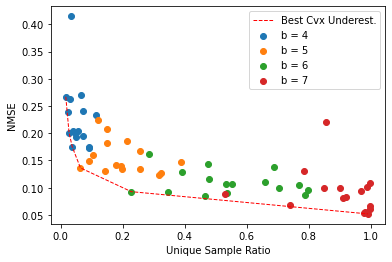

In [10]:
all_points = np.zeros(shape=[0,2])

for i, b in enumerate(b_list):
    s_values = np.mean(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()

    plt.scatter(s_values, mse_values, label = "b = {}".format(b))
    
    all_points = np.concatenate((all_points, np.array([s_values, mse_values]).T), axis = 0)

bcue = best_convex_underestimator(all_points)
plt.plot(bcue[:,0], bcue[:,1], 'r--', lw=1, label="Best Cvx Underest.")

plt.xlabel('Unique Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.show()

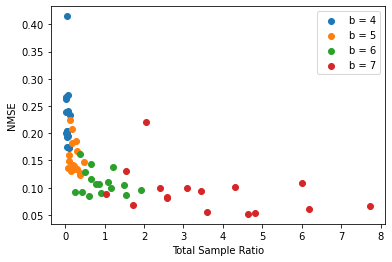

In [11]:
for i, b in enumerate(b_list):
    s_values = np.mean(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()

    plt.scatter(s_values, mse_values, label = "b = {}".format(b))

plt.xlabel('Total Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.show()